# Initialize environment

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
from os import remove
from scipy.io import loadmat
from itertools import compress
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from cobra.io import load_matlab_model
from urllib.request import urlretrieve

# Import CFR functions
from cfr_suite import cfr_optimize, apply_cfr, summarize, get_fluxes, process_flux

# Load MATLAB variables
mat = loadmat('tmp_out.mat')

c:\Users\carol\github\sandbox\COBRApy\.venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab._mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


## Define comparison function

In [6]:
def cfr_comparison(ax=None, x:str='x', y:str='y', o1:float=np.nan, o2:float=np.nan, v1=None, v2=None, 
                   v_limit:float=None, rxns=None, title='', plot_all:bool=True, fill=False, obj=False): 
    """

    Visually compare two COBRA solutions.
    
    """
    # Assert variable length match
    assert len(v1)==len(v2)
    assert len(v1)==len(rxns)

    # Apply limit (if prompted)
    if v_limit is not None: 
        v2[abs(v2) > v_limit] = np.nan

    # Deal with discrepancies
    diff = abs(v1-v2)
    lim = 0.1*max(pd.concat((v1, v2)))
    idx = diff > lim
    if plot_all is False: 
        rxns, v1, v2 = compress(rxns, ~idx), v1[~idx], v2[~idx]
        action = 'removed'
    else: 
        action = 'found'

    # Define data
    df = pd.DataFrame({'Reaction': rxns, x: v1, y: v2})

    # Determine correlation
    n = df.shape[0]
    ix = (np.isnan(v1) | np.isnan(v2))
    r, p = pearsonr(v1[~ix], v2[~ix])

    # Generate plot
    if ax==None: 
        ax = sns.scatterplot(data=df, x=x, y=y)
    else: 
        sns.scatterplot(data=df, x=x, y=y, ax=ax)

    # Add confidence bands (if prompted)
    xpoint = pd.concat((v1, v2)).mean()
    ax.axline((xpoint, xpoint), slope=1, color='k', linestyle='--')
    if fill: 
        # lims = [min(pd.concat((v1, v2))), max(pd.concat((v1, v2)))]
        # ax.plot(lims, lims, 'k--')
        x1 = np.linspace(min(pd.concat((v1, v2))), max(pd.concat((v1, v2))), len(v1))
        y1, y2 = x1-lim, x1+lim
        ax.fill_between(x1, y1, y2, alpha=0.2)

    # Add annotations
    ax.set_title(title)
    ax.text(0.02, 0.98, 'N = {}\nR = {:.3f}\np = {:.0e}'.format(n, r, p), 
            ha='left', va='top', transform=ax.transAxes)
    
    # Add comparison summary
    if obj: 
        ax.text(0.98, 0.02, 'Mean obj ({}) = {:.3f}\nMean obj ({}) = {:.3f}\n{} discrepancies {}\n{:.1%} disagreement'.format(x, o1, y, o2, sum(idx), action, sum(idx)/n), 
                ha='right', va='bottom', transform=ax.transAxes)
    else: 
        ax.text(0.98, 0.02, '{} obj = {:.3f}\n{} obj = {:.3f}\n{} discrepancies {}\n{:.1%} disagreement'.format(x, o1, y, o2, sum(idx), action, sum(idx)/n), 
                ha='right', va='bottom', transform=ax.transAxes)
        
    # Return ax
    return ax

## Load GEMs (runtime: ~30 seconds)

In [2]:
# Define IDs and GEM names
id = ['core', 'eco', 'mtb', 'recon', 'human']
gem = ['e_coli_core', 'iJO1366', 'iEK1008', 'RECON1', 'iHuman']

# Instantiate output
cobra_models = dict()

# Load GEMs iteratively
fname = 'tmp_gem.mat'
for i, g in zip(id, gem): 
    print('Loading {} GEM'.format(g))
    if i=='recon': 
        cobra_models[i] = load_matlab_model('gems/recon1_fixed.mat')
    else: 
        if i=='human': 
            url = 'https://github.com/SysBioChalmers/Human-GEM/raw/refs/heads/main/model/Human-GEM.mat'
        else: 
            url = 'http://bigg.ucsd.edu/static/models/' + g + '.mat'
        urlretrieve(url, fname)
        cobra_models[i] = load_matlab_model(fname)
        cobra_models[i].id = g

# Clean up 
remove(fname)

Loading e_coli_core GEM


This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.


Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-04


No defined compartments in model e_coli_core. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Loading iJO1366 GEM


This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iJO1366. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


Loading iEK1008 GEM


No defined compartments in model iEK1008. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model mdl. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, l, m, n, r, x


Loading RECON1 GEM
Loading iHuman GEM


# Test CFR functions

## MATLAB vs. Python comparisons

Runtimes: 

* Core: ~1 second
* *E. coli*: ~2 seconds
* *M. tb*: ~1 second
* Human (RECON1): ~2 seconds
* Human (iHuman): ~6 seconds

Text(0.5, 0.98, 'iHuman model comparisons')

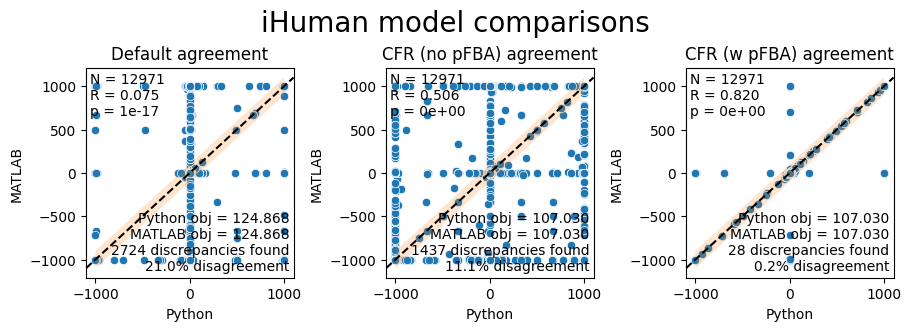

In [11]:
# Define ID
id = 'human'
with cobra_models[id] as model: 
    # Default optimization
    sol_def = model.optimize()

    # Extract reaction IDs
    rxns = sorted([rxn.id for rxn in model.reactions])

    # Extract subsystems
    subSystems = sorted([(g.id, g.name) for g in model.groups])

    # Get rxns in selected pathways
    if id=='mtb': 
        path1, path2 = 'Fatty Acid Metabolism', 'Purine and Pyrimidine Biosynthesis'
    elif id=='recon': 
        path1, path2 = 'Sphingolipid Metabolism', 'Nucleotides'
    elif id=='recon3d': 
        path1, path2 = 'Cholesterol metabolism', 'Peptide metabolism'
    elif id=='human': 
        path1, path2 = 'Glycolysis / Gluconeogenesis', 'Oxidative phosphorylation'
    else: 
        path1, path2 = 'Glycolysis/Gluconeogenesis', 'Oxidative Phosphorylation'
    gid1 = [id for id, pathway in subSystems if pathway==path1][0]
    gid2 = [id for id, pathway in subSystems if pathway==path2][0]

    # Define on/off rxns
    on_rxns = list(model.groups.get_by_id(gid1).members)
    off_rxns = list(model.groups.get_by_id(gid2).members)

    # Determine solutions
    sol_cfr = cfr_optimize(model, on_list=on_rxns, off_list=off_rxns, pfba_flag=False)
    sol_pfba = cfr_optimize(model, on_list=on_rxns, off_list=off_rxns, pfba_flag=True)
    v_limit = sol_def.fluxes.max()

# Define Python and MATLAB dataframes
df1 = pd.DataFrame({'Default': sol_def.fluxes, 'CFR': sol_cfr.fluxes, 'pFBA': sol_pfba.fluxes})
df2 = pd.DataFrame({'Rxn': [str(rxn[0][0]) for rxn in mat[id + '_rxns']], 'Default': mat[id + '_def_v'].reshape(-1), 
                    'CFR': mat[id + '_cfr_v'].reshape(-1), 'pFBA': mat[id + '_pfba_v'].reshape(-1)})
assert all(rxn in df1.index for rxn in df2['Rxn'])
df3 = df1.join(df2.set_index('Rxn'), lsuffix='_Python', rsuffix='_MATLAB')

# Instantiate figure
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3.2), constrained_layout=True)

# Plot default agreement
ax, title = axs[0], 'Default agreement'
o1, o2 = sol_def.objective_value, mat[id + '_def_f'][0][0]
v1, v2 = df3['Default_Python'], df3['Default_MATLAB']
cfr_comparison(ax=ax, x='Python', y='MATLAB', o1=o1, o2=o2, v1=v1, v2=v2, v_limit=v_limit, rxns=rxns, title=title, fill=True)

# Plot CFR (no pFBA) agreement
ax, title = axs[1], 'CFR (no pFBA) agreement'
o1, o2 = sol_cfr.objective_value, mat[id + '_cfr_f'][0][0]
v1, v2 = df3['CFR_Python'], df3['CFR_MATLAB']
cfr_comparison(ax=ax, x='Python', y='MATLAB', o1=o1, o2=o2, v1=v1, v2=v2, rxns=rxns, title=title, fill=True)

# Plot CFR (w pFBA) agreement
ax, title = axs[2], 'CFR (w pFBA) agreement'
o1, o2 = sol_pfba.objective_value, mat[id + '_pfba_f'][0][0]
v1, v2 = df3['pFBA_Python'], df3['pFBA_MATLAB']
cfr_comparison(ax=ax, x='Python', y='MATLAB', o1=o1, o2=o2, v1=v1, v2=v2, rxns=rxns, title=title, fill=True)

# Main title
fig.suptitle(model.id + ' model comparisons', fontsize=20)

## Gurobi vs. GLPK comparisons

Runtimes: 

* Core: ~3 seconds (gurobi: ~1 second)
* *E. coli*: ~24 seconds (gurobi: ~6 seconds)
* *M. tb*: ~12 seconds (gurobi: ~3 seconds)
* Human (RECON1): ~30 seconds (gurobi: ~8 seconds)
* Human (iHuman): ~4.5 minutes (gurobi: ~45 seconds)

Updating constraints: 100%|██████████| 8563/8563 [00:03<00:00, 2618.66it/s]


Defining objective
Objective defined


Updating constraints: 100%|██████████| 34485/34485 [00:14<00:00, 2365.57it/s]


Defining objective
Objective defined


Text(0.5, 0.98, 'iHuman model comparisons')

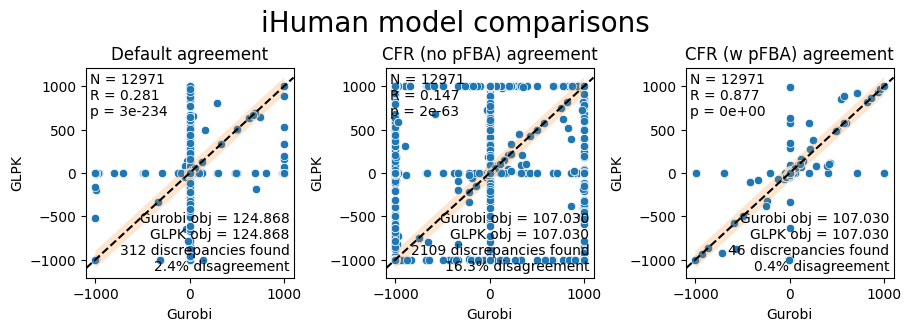

In [16]:
# Define ID
id = 'human'
with cobra_models[id] as model: 
    # Define inputs (gurobi)
    solver = 'gurobi'
    model.solver = solver

    # Extract CFR inputs
    rxns = sorted([rxn.id for rxn in model.reactions])
    subSystems = sorted([(g.id, g.name) for g in model.groups])
    if id=='mtb': 
        path1, path2 = 'Fatty Acid Metabolism', 'Purine and Pyrimidine Biosynthesis'
    elif id=='recon': 
        path1, path2 = 'Sphingolipid Metabolism', 'Nucleotides'
    elif id=='recon3d': 
        path1, path2 = 'Cholesterol metabolism', 'Peptide metabolism'
    elif id=='human': 
        path1, path2 = 'Glycolysis / Gluconeogenesis', 'Oxidative phosphorylation'
    else: 
        path1, path2 = 'Glycolysis/Gluconeogenesis', 'Oxidative Phosphorylation'
    gid1 = [id for id, pathway in subSystems if pathway==path1][0]
    gid2 = [id for id, pathway in subSystems if pathway==path2][0]
    on_rxns = list(model.groups.get_by_id(gid1).members)
    off_rxns = list(model.groups.get_by_id(gid2).members)

    # Determine solutions
    sol_def1 = model.optimize()
    with model: 
        sol_cfr1 = cfr_optimize(model, on_list=on_rxns, off_list=off_rxns, pfba_flag=False, solver=solver)
    with model: 
        sol_pfba1 = cfr_optimize(model, on_list=on_rxns, off_list=off_rxns, pfba_flag=True, solver=solver)
    df1 = pd.DataFrame({'Default': sol_def1.fluxes, 'CFR': sol_cfr1.fluxes, 'pFBA': sol_pfba1.fluxes})

    # Define inputs (GLPK)
    solver = 'glpk'
    model.solver = solver

    # Determine solutions
    sol_def2 = model.optimize()
    with model: 
        sol_cfr2 = cfr_optimize(model, on_list=on_rxns, off_list=off_rxns, pfba_flag=False, solver=solver)
    with model: 
        sol_pfba2 = cfr_optimize(model, on_list=on_rxns, off_list=off_rxns, pfba_flag=True, solver=solver)
    df2 = pd.DataFrame({'Default': sol_def2.fluxes, 'CFR': sol_cfr2.fluxes, 'pFBA': sol_pfba2.fluxes})

    # Join dataframes
    df3 = df1.join(df2, lsuffix='_Gurobi', rsuffix='_GLPK')

# Instantiate figure
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3.2), constrained_layout=True)

# Plot default agreement
ax, title = axs[0], 'Default agreement'
o1, o2 = sol_def1.objective_value, sol_def2.objective_value
v1, v2 = df3['Default_Gurobi'], df3['Default_GLPK']
cfr_comparison(ax=ax, x='Gurobi', y='GLPK', o1=o1, o2=o2, v1=v1, v2=v2, rxns=rxns, title=title, fill=True)

# Plot CFR (no pFBA) agreement
ax, title = axs[1], 'CFR (no pFBA) agreement'
o1, o2 = sol_cfr1.objective_value, sol_cfr2.objective_value
v1, v2 = df3['CFR_Gurobi'], df3['CFR_GLPK']
cfr_comparison(ax=ax, x='Gurobi', y='GLPK', o1=o1, o2=o2, v1=v1, v2=v2, rxns=rxns, title=title, fill=True)

# Plot CFR (w pFBA) agreement
ax, title = axs[2], 'CFR (w pFBA) agreement'
o1, o2 = sol_pfba1.objective_value, sol_pfba2.objective_value
v1, v2 = df3['pFBA_Gurobi'], df3['pFBA_GLPK']
cfr_comparison(ax=ax, x='Gurobi', y='GLPK', o1=o1, o2=o2, v1=v1, v2=v2, rxns=rxns, title=title, fill=True)

# Main title
fig.suptitle(model.id + ' model comparisons', fontsize=20)

## Literature-based evaluation

Runtimes: 

* *E. coli* (iJO1366): ~3 minutes
* *M. tb* (iEK1008): ~1 minute
* *H. sapiens* (RECON1): ~1.5 minutes
* *H. sapiens* (iHuman): ~2 minutes

Applying CFR across 29 conditions: 100%|██████████| 29/29 [01:39<00:00,  3.42s/it]


<Axes: title={'center': 'Literature-based solutions (iHuman)'}, xlabel='Python', ylabel='MATLAB'>

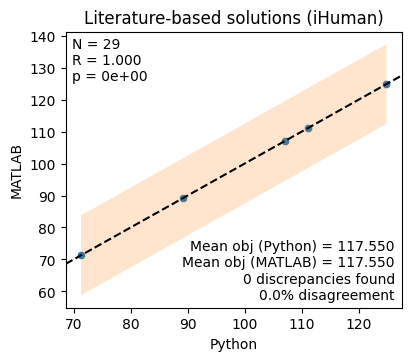

In [ ]:
# Define ID
save_data = False
id = 'human'
model = cobra_models[id]

# Load omics data
if id=='eco':   
    df = pd.read_excel('data/literature_omics.xlsx', sheet_name='ecoli_chemogenomics', index_col=0, engine='openpyxl')
elif id=='mtb': 
    df = pd.read_excel('data/literature_omics.xlsx', sheet_name='mtb_transcriptomics', index_col=0, engine='openpyxl')
elif id=='recon': 
    df = pd.read_excel('data/Melanoma-phs000452-recon1.xlsx', index_col=0, engine='openpyxl')
elif id=='human': 
    df = pd.read_csv('data/literature_cancer.tsv', sep='\t', header=0)
    df = df.pivot(index='Gene', columns='Cancer', values='nTPM')

# Apply z-score normalization
if id=='human': 
    df = np.log2(df+1)
if id=='recon': 
    dfz = df.copy()
else: 
    dfz = df.sub(df.median(axis=1), axis=0).div(df.std(axis=1), axis=0)

# Save data (if prompted)
if save_data: 
    with cobra_models[id] as model: 
        genes = [gene.id for gene in model.genes]
    df = dfz[dfz.index.isin(genes)]
    with pd.ExcelWriter('./data/test_cfr.xlsx', mode='a', if_sheet_exists='replace') as file:
	    df.to_excel(file, sheet_name=id, index=True, engine='openpyxl', freeze_panes=(1, 1))

# Determine results
results = apply_cfr(model, dfz, thresh=(-1, 1))

# Summarize results
df = summarize(results)

# Get MATLAB results
df['MATLAB'] = mat['{}_obj'.format(id)]
rxns = df.index.tolist()
v1, v2 = df['Objective'], df['MATLAB']
o1, o2 = v1.mean(), v2.mean()

# Visualize results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3.5), constrained_layout=True)
title = 'Literature-based solutions ({})'.format(model.id)
cfr_comparison(ax=ax, x='Python', y='MATLAB', v1=v1, v2=v2, o1=o1, o2=o2, obj=True, rxns=rxns, title=title, fill=True)

# Application: predicting patient-specific outcomes

Predict patient-specific outcomes via 5-fold CV.

Runtimes: 
* RECON1: ~2 minutes
* iHuman: ~10 minutes

In [ ]:
# Import dependencies
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Specify COBRA model
id = 'recon'
if 'model' not in locals(): 
    if id=='recon': 
        fname = 'gems/recon1_fixed.mat'♦
    elif id=='human': 
        fname = 'tmp_gem.mat'
        url = 'https://github.com/SysBioChalmers/Human-GEM/raw/refs/heads/main/model/Human-GEM.mat'
        urlretrieve(url, fname)
    model = load_matlab_model(fname)
elif model.id not in ('mdl', 'RECON1', 'ihuman'): 
    if 'cobra_models' in locals(): 
        model = cobra_models[id]
    else: 
        if id=='recon': 
            fname = 'gems/recon1_fixed.mat'
        elif id=='human': 
            fname = 'tmp_gem.mat'
            url = 'https://github.com/SysBioChalmers/Human-GEM/raw/refs/heads/main/model/Human-GEM.mat'
            urlretrieve(url, fname)
        model = load_matlab_model(fname)
if id=='recon': 
    model.id = 'RECON1'
elif id=='human': 
    model.id = 'iHuman'

# Load omics data
if id=='recon': 
    ext = 'recon1'
elif id=='human': 
    ext = 'ihuman'
data = {
    'omics': pd.read_excel('data/Melanoma-phs000452-' + ext + '.xlsx', index_col=0, engine='openpyxl'), 
    'meta': pd.read_excel('data/Melanoma-phs000452-metadata.xlsx', index_col=0, engine='openpyxl')
}

# Determine CFR results
weight = 0.01
params = (weight, 0.001)
if ('results' not in locals()) or (len(results)!=data['omics'].shape[1]): 
    results = apply_cfr(model, data['omics'], thresh=(-1, 1), on_params=params, off_params=params)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-04


No defined compartments in model mdl. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, l, m, n, r, x
Applying CFR across 153 conditions: 100%|██████████| 153/153 [03:12<00:00,  1.26s/it]


In [4]:
# Extract flux profiles
data['flux'] = get_fluxes(results)

# Process flux data
data['bin'] = process_flux(model, data['flux'])

Train-test score:	0.3871
5-fold CV score:	0.5290


Text(0.6, 1.1, 'GEM: RECON1, Mode: flux, Entropy: True, k = r = 0.010')

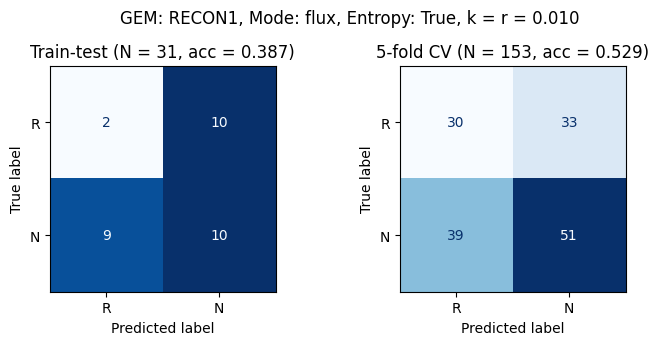

In [24]:
# Define ML inputs
mode = 'flux'
add_entropy = True
rem_zero_var = False
df = data[mode].copy()
if add_entropy: 
    df.loc['entropy'] = np.log(data['flux'].var())
if rem_zero_var: 
    idx = df[df.var(axis=1)==0].index
    df.drop(idx, axis=0, inplace=True)
X = df.to_numpy().transpose()
y = data['meta']['response_NR'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# Evaluate train-test
# classifier = RandomForestClassifier()
classifier = SVC(kernel='linear', class_weight='balanced', random_state=0, C=1)
score = clone(classifier).fit(X_train, y_train).score(X_test, y_test)
print('Train-test score:\t{:.4f}'.format(score))

# Evaluate 5-fold CV
scores = cross_val_score(clone(classifier), X, y, cv=5)
print('5-fold CV score:\t{:.4f}'.format(scores.mean()))

# Instantiate figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), constrained_layout=True)

# Train-test
y_pred = clone(classifier).fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=['R', 'N'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['R', 'N'])
disp.plot(cmap=plt.cm.Blues, ax=axs[0])
disp.im_.colorbar.remove()
disp.ax_.set_title('Train-test (N = {}, acc = {:.3f})'.format(len(y_pred), (y_test==y_pred).sum()/len(y_pred)))

# 5-fold CV
y_pred = cross_val_predict(clone(classifier), X, y, cv=5)
cm = confusion_matrix(y, y_pred, labels=['R', 'N'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['R', 'N'])
disp.plot(cmap=plt.cm.Blues, ax=axs[1])
disp.im_.colorbar.remove()
disp.ax_.set_title('5-fold CV (N = {}, acc = {:.3f})'.format(len(y_pred), (y==y_pred).sum()/len(y_pred)))

# Add suptitle
plt.suptitle('GEM: {}, Mode: {}, Entropy: {}, k = r = {:.3f}'.format(model.id, mode, str(add_entropy), weight), x=0.6, y=1.1)

In [ ]:
try: 
    del results
except: 
    print('Variable `results` already deleted')
try: 
    del model
except: 
    print('Variable `model` already deleted')

## Evaluate multiple classifiers

c:\Users\carol\github\sandbox\COBRApy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\carol\github\sandbox\COBRApy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\carol\github\sandbox\COBRApy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\carol\github\sandbox\COBRApy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

Text(0.6, 1.01, 'GEM: RECON1, Mode: flux, Entropy: True, k = r = 0.010')

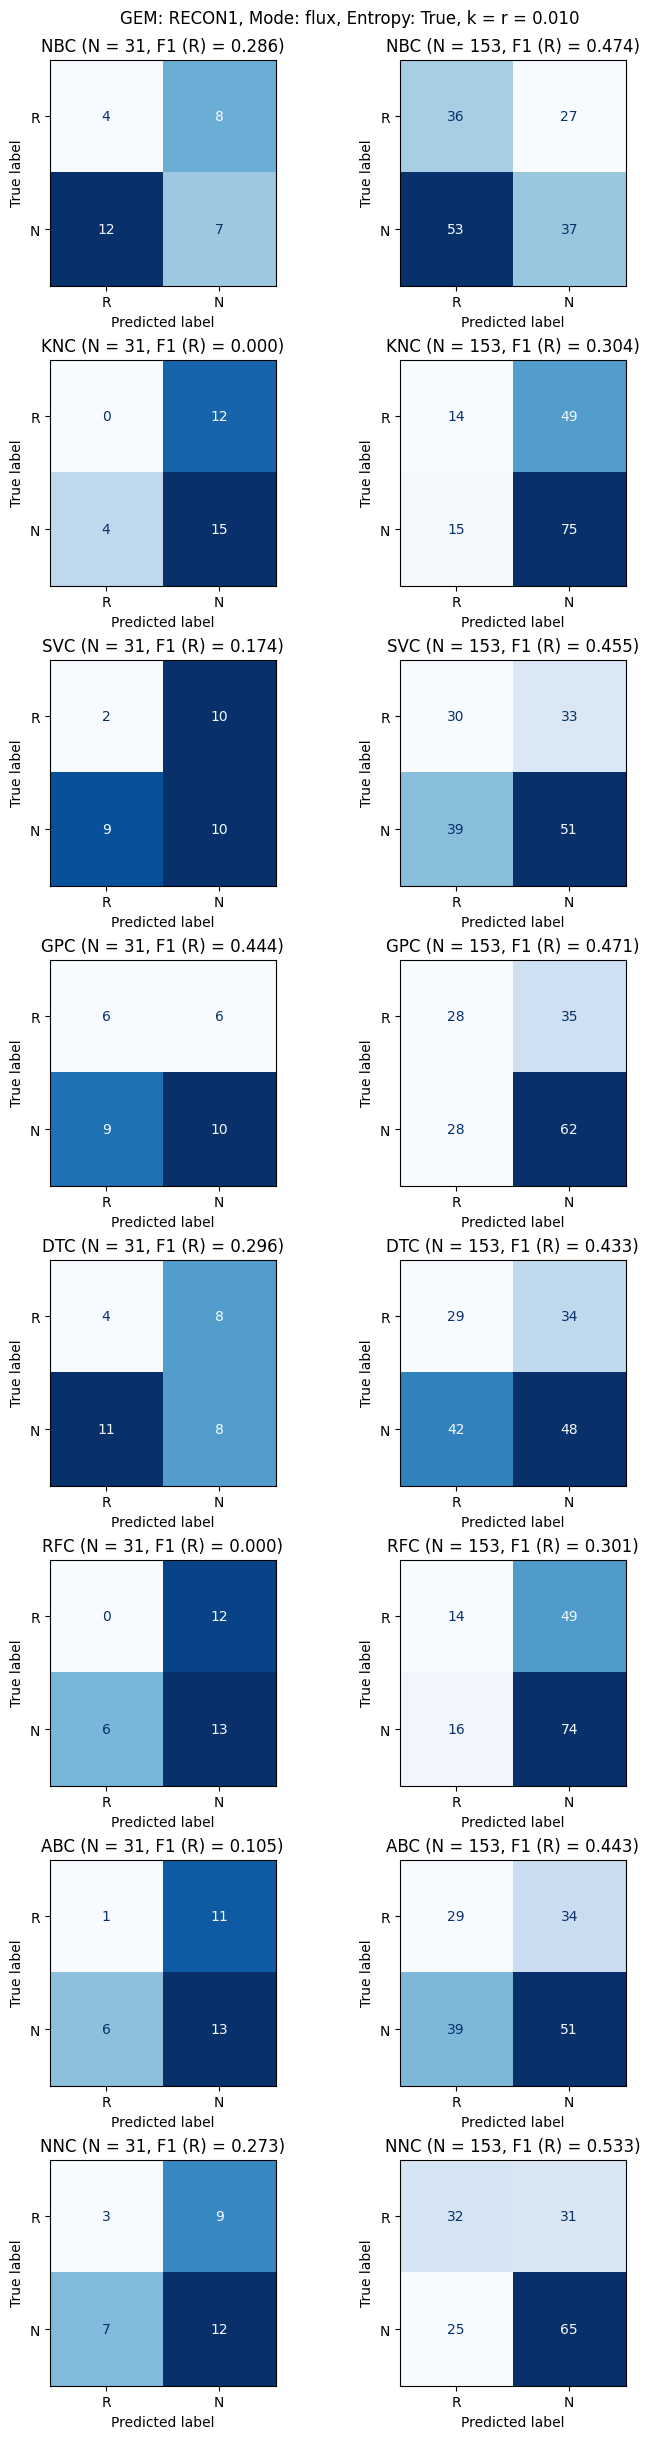

In [25]:
# Import models
from sklearn.base import clone
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB as NBC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.neural_network import MLPClassifier as NNC

# Define user inputs
mode = 'flux'
add_entropy = True
rem_zero_var = False

# Define input data
df = data[mode].copy()
if not add_entropy: 
    df = df.iloc[:-1, :]
if rem_zero_var: 
    idx = df[df.var(axis=1)==0].index
    df.drop(idx, axis=0, inplace=True)

# Define ML inputs
X = df.to_numpy().transpose()
y = data['meta']['response_NR'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# Define classifiers
c_names = ['NBC', 'KNC', 'SVC', 'GPC', 'DTC', 'RFC', 'ABC', 'NNC']
c_models = [NBC(), KNC(2), SVC(kernel='linear', random_state=0, class_weight='balanced'), 
            GPC(), DTC(random_state=0, class_weight='balanced'), 
            RFC(random_state=0, class_weight='balanced'), 
            ABC(random_state=0), NNC(random_state=0)]

# Instantiate figure
n = int(len(c_names))
fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(7, 3*n), constrained_layout=True)

# Iterate through each model
acc, f1r, f1n = [], [], []
for i, (name, classifier) in enumerate(zip(c_names, c_models)): 
    # Train-test
    ax = axs[i, 0]
    y_pred = clone(classifier).fit(X_train, y_train).predict(X_test)
    score = f1_score(y_test, y_pred, pos_label='R')
    cm = confusion_matrix(y_test, y_pred, labels=['R', 'N'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['R', 'N'])
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    disp.im_.colorbar.remove()
    disp.ax_.set_title('{} (N = {}, F1 (R) = {:.3f})'.format(name, len(y_pred), score))
    # 5-fold CV
    ax = axs[i, 1]
    y_pred = cross_val_predict(clone(classifier), X, y, cv=5)
    score = f1_score(y, y_pred, pos_label='R')
    cm = confusion_matrix(y, y_pred, labels=['R', 'N'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['R', 'N'])
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    disp.im_.colorbar.remove()
    disp.ax_.set_title('{} (N = {}, F1 (R) = {:.3f})'.format(name, len(y_pred), score))
    # Save metrics
    acc.append(accuracy_score(y, y_pred))
    f1r.append(f1_score(y, y_pred, pos_label='R'))
    f1n.append(f1_score(y, y_pred, pos_label='N'))
dfs = pd.DataFrame({'Classifier': c_names, 'Accuracy': acc, 'F1_R': f1r, 'F1_N': f1n})

# Add suptitle
plt.suptitle('GEM: {}, Mode: {}, Entropy: {}, k = r = {:.3f}'.format(model.id, mode, str(add_entropy), weight), x=0.6, y=1.01)

In [26]:
# Define C values
c_values = np.arange(start=0.1, stop=10.1, step=0.1)

# Iterate
acc, f1r, f1n = [], [], []
for i, c_val in enumerate(c_values): 
    # Define classifier
    classifier = SVC(kernel='linear', random_state=0, class_weight='balanced', C=c_val)
    # Generate predictions
    y_pred = cross_val_predict(classifier, X, y, cv=5)
    # Save metrics
    acc.append(accuracy_score(y, y_pred))
    f1r.append(f1_score(y, y_pred, pos_label='R'))
    f1n.append(f1_score(y, y_pred, pos_label='N'))
dfs = pd.DataFrame({'C': c_values, 'Accuracy': acc, 'F1_R': f1r, 'F1_N': f1n})

Text(0.5, 1.0, 'SVC performance across C values')

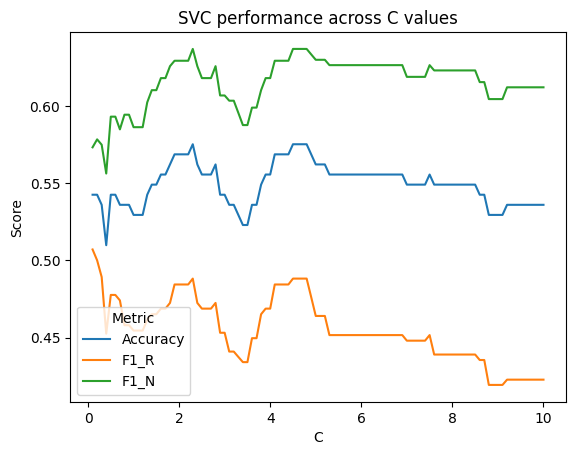

In [27]:
import seaborn as sns
dfm = dfs.melt('C', var_name='Metric', value_name='Score')
sns.lineplot(data=dfm, x='C', y='Score', hue='Metric')
plt.title('SVC performance across C values')

In [28]:
for col in dfs.columns[1:]: 
    print('Max {} = {:.4f}'.format(col, dfs[col].max()))
    display(dfs[dfs[col]==dfs[col].max()])

Max Accuracy = 0.5752


,C,Accuracy,F1_R,F1_N
22,2.3,0.575163,0.488189,0.636872
44,4.5,0.575163,0.488189,0.636872
45,4.6,0.575163,0.488189,0.636872
46,4.7,0.575163,0.488189,0.636872
47,4.8,0.575163,0.488189,0.636872


Max F1_R = 0.5070


,C,Accuracy,F1_R,F1_N
0,0.1,0.542484,0.507042,0.573171


Max F1_N = 0.6369


,C,Accuracy,F1_R,F1_N
22,2.3,0.575163,0.488189,0.636872
44,4.5,0.575163,0.488189,0.636872
45,4.6,0.575163,0.488189,0.636872
46,4.7,0.575163,0.488189,0.636872
47,4.8,0.575163,0.488189,0.636872


Text(0.5, 1.0, 'SVC (C = 2.3) (N = 153, F1 (R) = 0.488)')

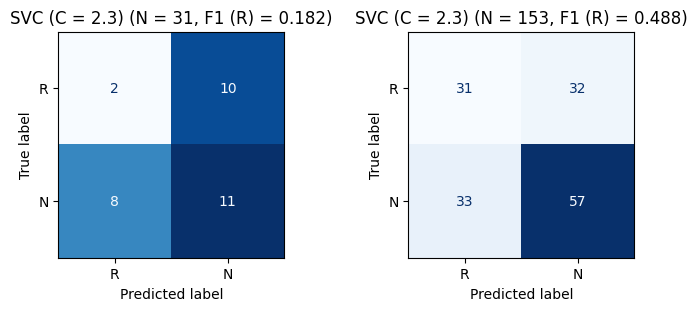

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), constrained_layout=True)

# Train-test
c = 2.3
name = 'SVC (C = {:.1f})'.format(c)
ax = axs[0]
classifier = SVC(kernel='linear', class_weight='balanced', C=c, random_state=0)
y_pred = clone(classifier).fit(X_train, y_train).predict(X_test)
score = f1_score(y_test, y_pred, pos_label='R')
cm = confusion_matrix(y_test, y_pred, labels=['R', 'N'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['R', 'N'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
disp.im_.colorbar.remove()
disp.ax_.set_title('{} (N = {}, F1 (R) = {:.3f})'.format(name, len(y_pred), score))
# 5-fold CV
ax = axs[1]
y_pred = cross_val_predict(clone(classifier), X, y, cv=5)
score = f1_score(y, y_pred, pos_label='R')
cm = confusion_matrix(y, y_pred, labels=['R', 'N'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['R', 'N'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
disp.im_.colorbar.remove()
disp.ax_.set_title('{} (N = {}, F1 (R) = {:.3f})'.format(name, len(y_pred), score))

# End